<a href="https://colab.research.google.com/github/hexeeyy/scoliosis/blob/main/scoliosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import necessary libraries**

In [1]:
!pip install mediapipe

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import json
import os
import mediapipe as mp
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from google.colab import drive
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight

# Print versions
print("✅ NumPy version:", np.__version__)
print("✅ TensorFlow version:", tf.__version__)

✅ NumPy version: 1.26.4
✅ TensorFlow version: 2.18.0


In [2]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Set dataset path
dataset_path = "/content/drive/MyDrive/final_na_talaga/dataset"

# Check if the dataset path exists
if os.path.exists(dataset_path):
    print("✅ Dataset path exists!")
    # List folders and files inside
    print("Contents:", os.listdir(dataset_path))
else:
    print("❌ Dataset path does NOT exist. Check the path again.")

✅ Dataset path exists!
Contents: ['data.yaml', 'resnet50_scoliosis_model.h5', 'severe', 'moderate', 'normal', 'mild']


In [4]:
# Initialize MediaPipe Pose (optional, not used here but kept for compatibility)
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

In [5]:
# Function to calculate Cobb angle from keypoints (simplified)
def calculate_cobb_angle(keypoints):
    keypoints = keypoints.reshape(-1, 2)  # Reshape to (17, 2)
    upper_spine = (keypoints[5] + keypoints[6]) / 2  # Midpoint of shoulders
    lower_spine = (keypoints[11] + keypoints[12]) / 2  # Midpoint of hips
    delta_y = upper_spine[1] - lower_spine[1]
    delta_x = upper_spine[0] - lower_spine[0]
    angle_radians = math.atan2(delta_y, delta_x)
    angle_degrees = math.degrees(angle_radians)
    return min(abs(angle_degrees), 90)  # Cap at 90°

# Load keypoints and calculate Cobb angles from JSON
def load_keypoints_and_angles_from_json(base_folder):
    keypoints_data = []
    cobb_angles = []
    labels = []
    class_folders = ['normal', 'mild', 'moderate', 'severe']
    class_mapping = {'normal': 0, 'mild': 1, 'moderate': 2, 'severe': 3}
    expected_length = 34  # 17 keypoints * (x, y)

    for class_name in class_folders:
        class_path = os.path.join(base_folder, class_name)
        for split in ['train', 'valid', 'test']:
            split_path = os.path.join(class_path, split)
            annotation_file = os.path.join(split_path, '_annotations.coco.json')
            if os.path.exists(annotation_file):
                with open(annotation_file, 'r') as f:
                    annotations = json.load(f)
                    for ann in annotations['annotations']:
                        keypoints = np.array(ann['keypoints']).reshape(-1, 3)[:, :2].flatten()
                        if len(keypoints) < expected_length:
                            keypoints = np.pad(keypoints, (0, expected_length - len(keypoints)), 'constant')
                        elif len(keypoints) > expected_length:
                            keypoints = keypoints[:expected_length]
                        keypoints_data.append(keypoints)
                        cobb_angles.append(calculate_cobb_angle(keypoints))
                        labels.append(class_mapping[class_name])

    return np.array(keypoints_data, dtype=np.float32), np.array(cobb_angles, dtype=np.float32), np.array(labels, dtype=np.int32)

# Data augmentation function
def augment_keypoints(keypoints, max_shift=0.05, max_scale=0.1, max_rotate=10):
    keypoints = keypoints.reshape(-1, 2)  # Reshape to (17, 2)
    shift_x = np.random.uniform(-max_shift, max_shift) * np.max(keypoints[:, 0])
    shift_y = np.random.uniform(-max_shift, max_shift) * np.max(keypoints[:, 1])
    keypoints[:, 0] += shift_x
    keypoints[:, 1] += shift_y
    scale = 1 + np.random.uniform(-max_scale, max_scale)
    keypoints *= scale
    angle = np.radians(np.random.uniform(-max_rotate, max_rotate))
    cos_val, sin_val = np.cos(angle), np.sin(angle)
    rotation_matrix = np.array([[cos_val, -sin_val], [sin_val, cos_val]])
    keypoints = keypoints.dot(rotation_matrix)
    return keypoints.flatten()

# Load dataset
X, cobb_angles, y = load_keypoints_and_angles_from_json(dataset_path)
X = X / np.max(X)  # Normalize keypoints
cobb_angles = cobb_angles / 90.0  # Normalize angles to [0, 1]

# Split dataset: 96% train, 3% validation, 1% test
X_train, X_temp, y_train, y_temp, cobb_train, cobb_temp = train_test_split(
    X, y, cobb_angles, test_size=0.04, random_state=42
)
X_val, X_test, y_val, y_test, cobb_val, cobb_test = train_test_split(
    X_temp, y_temp, cobb_temp, test_size=0.25, random_state=42
)

# Augment training data
X_train_aug = np.array([augment_keypoints(x) for x in X_train])
X_train_combined = np.concatenate([X_train, X_train_aug])
y_train_combined = np.concatenate([y_train, y_train])
cobb_train_combined = np.concatenate([cobb_train, cobb_train])

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Prepare sample weights
sample_weights_combined = {
    'classification': np.array([class_weights_dict[label] for label in y_train_combined]),
    'cobb_angle': np.ones(len(y_train_combined))
}

# Build ResNet-style model
def residual_block(x, units):
    shortcut = x
    x = layers.Dense(units, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(units, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    if shortcut.shape[-1] != units:
        shortcut = layers.Dense(units, kernel_regularizer=l2(0.001))(shortcut)
    x = layers.Add()([shortcut, x])
    return x

def build_resnet_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(inputs)
    x = layers.BatchNormalization(momentum=0.9)(x)
    for units in [256, 512, 1024]:
        x = residual_block(x, units)
        x = layers.Dropout(0.2)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    class_output = layers.Dense(4, activation='softmax', name='classification')(x)
    angle_output = layers.Dense(1, activation='linear', name='cobb_angle')(x)

    model = keras.Model(inputs=inputs, outputs=[class_output, angle_output])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss={'classification': 'sparse_categorical_crossentropy', 'cobb_angle': 'mse'},
        metrics={'classification': 'accuracy', 'cobb_angle': 'mae'}
    )
    return model

Model output names: ListWrapper(['classification', 'cobb_angle'])
X_train_combined shape: (16756, 34)
y_train_combined shape: (16756,)
cobb_train_combined shape: (16756,)
Sample weights keys: dict_keys(['classification', 'cobb_angle'])
Sample weights classification shape: (16756,)
Sample weights cobb_angle shape: (16756,)
Sample weights classification type: <class 'numpy.ndarray'>
Sample weights cobb_angle type: <class 'numpy.ndarray'>
Epoch 1/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 185ms/step - classification_accuracy: 0.4575 - classification_loss: 1.4866 - cobb_angle_loss: 2.0338 - cobb_angle_mae: 1.0811 - loss: 8.4337 - val_classification_accuracy: 0.6183 - val_classification_loss: 0.6973 - val_cobb_angle_loss: 0.2702 - val_cobb_angle_mae: 0.4381 - val_loss: 5.9906 - learning_rate: 1.0000e-04
Epoch 2/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - classification_accuracy: 0.5990 - classification_loss: 0.9589 - cobb_angle_loss: 0.8398 - cobb_angle_mae: 0.7093 - loss: 6.6919 - val_classifi

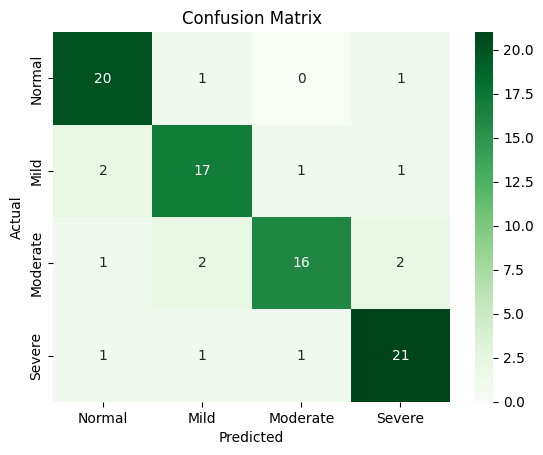

Classification Report:
              precision    recall  f1-score   support

      Normal       0.83      0.91      0.87        22
        Mild       0.81      0.81      0.81        21
    Moderate       0.89      0.76      0.82        21
      Severe       0.84      0.88      0.86        24

    accuracy                           0.84        88
   macro avg       0.84      0.84      0.84        88
weighted avg       0.84      0.84      0.84        88



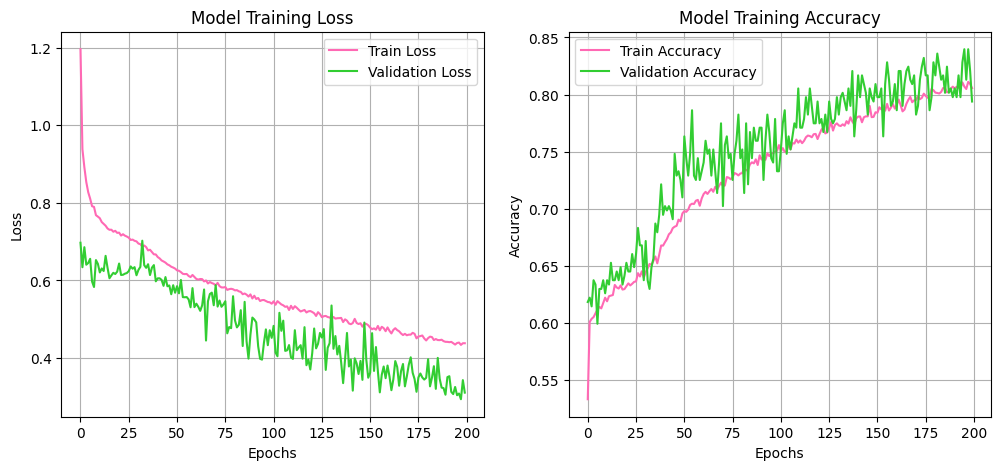

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


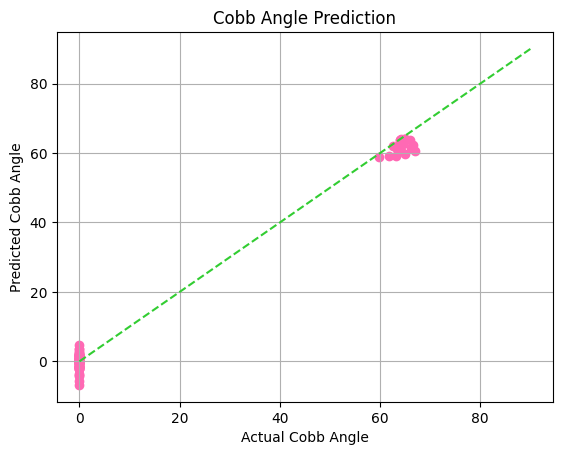

Model saved to Google Drive as 'scoliosis_optimized_resnet.h5'


In [ ]:
# Build and compile the model (ensure this matches your definition)
def build_resnet_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(inputs)
    x = layers.BatchNormalization(momentum=0.9)(x)
    for units in [256, 512, 1024]:
        x = residual_block(x, units)
        x = layers.Dropout(0.2)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    class_output = layers.Dense(4, activation='softmax', name='classification')(x)
    angle_output = layers.Dense(1, activation='linear', name='cobb_angle')(x)

    model = keras.Model(inputs=inputs, outputs=[class_output, angle_output])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss={'classification': 'sparse_categorical_crossentropy', 'cobb_angle': 'mse'},
        metrics={'classification': 'accuracy', 'cobb_angle': 'mae'}
    )
    return model

# Create the model
model = build_resnet_model(input_shape=(X.shape[1],))

# Debug shapes and output names
print("Model output names:", model.output_names)
print("X_train_combined shape:", X_train_combined.shape)
print("y_train_combined shape:", y_train_combined.shape)
print("cobb_train_combined shape:", cobb_train_combined.shape)
print("Sample weights keys:", sample_weights_combined.keys())

# Ensure sample weights match the number of samples
assert len(sample_weights_combined['classification']) == X_train_combined.shape[0], "Sample weights mismatch for classification"
assert len(sample_weights_combined['cobb_angle']) == X_train_combined.shape[0], "Sample weights mismatch for cobb_angle"

# Train the model
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
]

print("Sample weights classification shape:", sample_weights_combined['classification'].shape)
print("Sample weights cobb_angle shape:", sample_weights_combined['cobb_angle'].shape)
print("Sample weights classification type:", type(sample_weights_combined['classification']))
print("Sample weights cobb_angle type:", type(sample_weights_combined['cobb_angle']))

# Convert sample weights to list format (order matches model.output_names)
sample_weights_list = [
    sample_weights_combined['classification'],
    sample_weights_combined['cobb_angle']
]

# Train with sample weights as a list
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
]

history = model.fit(
    X_train_combined,
    [y_train_combined, cobb_train_combined],  # Targets as list
    epochs=200,
    batch_size=256,
    validation_data=(X_val, [y_val, cobb_val]),  # Validation as list
    sample_weight=sample_weights_list,  # Sample weights as list
    callbacks=callbacks,
    verbose=1
)

# Evaluate model
eval_results = model.evaluate(X_test, {'classification': y_test, 'cobb_angle': cobb_test})
print(f'Test Loss: {eval_results[0]}, Classification Accuracy: {eval_results[1]}, Cobb Angle MAE: {eval_results[2]}')

# Confusion Matrix
y_pred = np.argmax(model.predict(X_test)[0], axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d',
            xticklabels=['Normal', 'Mild', 'Moderate', 'Severe'],
            yticklabels=['Normal', 'Mild', 'Moderate', 'Severe'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\033[92mClassification Report:\033[0m")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Mild', 'Moderate', 'Severe']))

# Plot training loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['classification_loss'], label='Train Loss', color='hotpink')
plt.plot(history.history['val_classification_loss'], label='Validation Loss', color='limegreen')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Training Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['classification_accuracy'], label='Train Accuracy', color='hotpink')
plt.plot(history.history['val_classification_accuracy'], label='Validation Accuracy', color='limegreen')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Training Accuracy')
plt.grid(True)
plt.show()

# Plot Cobb angle predictions
cobb_pred = model.predict(X_test)[1].flatten() * 90  # Denormalize
plt.scatter(cobb_test * 90, cobb_pred, c='hotpink')
plt.plot([0, 90], [0, 90], 'limegreen', ls='--')
plt.xlabel('Actual Cobb Angle')
plt.ylabel('Predicted Cobb Angle')
plt.title('Cobb Angle Prediction')
plt.grid(True)
plt.show()

# Save model
model.save("/content/drive/MyDrive/scoliosis_optimized_resnet.h5")
print("Model saved to Google Drive as 'scoliosis_optimized_resnet.h5'")

In [6]:
# Save the model in .keras format
model.save('/content/drive/MyDrive/scoliosis_optimized_resnet.keras')
print("Model saved successfully in .keras format!")

NameError: name 'model' is not defined

In [7]:
from tensorflow.keras.models import load_model
import numpy as np

# Load the model
model_path = '/content/drive/MyDrive/scoliosis_optimized_resnet.keras'  # or .h5
model = load_model(model_path)
print("Model loaded successfully!")

# Test with a sample
sample_keypoints = X_test[0:1]  # Shape: (1, 34)
true_label = y_test[0]
true_cobb = cobb_test[0] * 90  # Denormalize (scalar)
predictions = model.predict(sample_keypoints)
class_pred = np.argmax(predictions[0], axis=1)[0]  # Scalar class index
cobb_pred = predictions[1][0][0] * 90  # Extract scalar value from (1, 1) array

class_names = ['Normal', 'Mild', 'Moderate', 'Severe']
print(f"Predicted Class: {class_names[class_pred]} (True: {class_names[true_label]})")
print(f"Predicted Cobb Angle: {cobb_pred:.2f}° (True: {true_cobb:.2f}°)")

Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
Predicted Class: Severe (True: Severe)
Predicted Cobb Angle: -4.27° (True: 0.00°)


In [ ]:
# Install TensorFlow.js converter
!pip install tensorflowjs

# Convert the model
import tensorflowjs as tfjs
model = load_model('/content/drive/MyDrive/scoliosis_optimized_resnet.keras')  # or .h5
tfjs.converters.save_keras_model(model, '/content/scoliosis_tfjs_model')
print("Model converted to TensorFlow.js format!")

# Zip and download
!zip -r scoliosis_tfjs_model.zip /content/scoliosis_tfjs_model
from google.colab import files
files.download('scoliosis_tfjs_model.zip')

  Using cached protobuf-5.29.4-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
Using cached protobuf-5.29.4-cp38-abi3-manylinux2014_x86_64.whl (319 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires protobuf<5,>=4.25.3, but you have protobuf 5.29.4 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.


failed to lookup keras version from the file,
    this is likely a weight only file
Model converted to TensorFlow.js format!
  adding: content/scoliosis_tfjs_model/ (stored 0%)
  adding: content/scoliosis_tfjs_model/group1-shard4of4.bin (deflated 7%)
  adding: content/scoliosis_tfjs_model/model.json (deflated 93%)
  adding: content/scoliosis_tfjs_model/group1-shard1of4.bin (deflated 7%)
  adding: content/scoliosis_tfjs_model/group1-shard3of4.bin (deflated 7%)
  adding: content/scoliosis_tfjs_model/group1-shard2of4.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
print("TensorFlow version:", tf.__version__)
print("OpenCV version:", cv2.__version__)
print("MediaPipe version:", mp.__version__)
print("NumPy version:", np.__version__)

TensorFlow version: 2.18.0
OpenCV version: 4.11.0
MediaPipe version: 0.10.21
NumPy version: 1.26.4


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.models import load_model

# Function to capture webcam image
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Load the model
model_path = '/content/drive/MyDrive/scoliosis_optimized_resnet.keras'  # Update if needed
model = load_model(model_path)
print("Model loaded successfully!")

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# Capture image from webcam
try:
    filename = take_photo()
    print(f"Saved webcam image to {filename}")

    # Read and process the image
    image = cv2.imread(filename)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        # Draw landmarks (optional, for visualization)
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        # Extract keypoints
        keypoints = np.array([[lm.x, lm.y] for lm in results.pose_landmarks.landmark[:17]]).flatten()  # Shape: (34,)
        keypoints = keypoints / np.max(keypoints)  # Normalize
        keypoints = np.expand_dims(keypoints, axis=0)  # Shape: (1, 34)

        # Predict
        predictions = model.predict(keypoints, verbose=0)
        class_pred = np.argmax(predictions[0], axis=1)[0]
        cobb_pred = predictions[1][0][0] * 90  # Denormalize

        # Display results
        class_names = ['Normal', 'Mild', 'Moderate', 'Severe']
        print(f"Predicted Class: {class_names[class_pred]}")
        print(f"Predicted Cobb Angle: {cobb_pred:.2f}°")

        # Show image with landmarks (optional)
        from google.colab.patches import cv2_imshow
        cv2_imshow(image)
    else:
        print("No pose detected in the image.")

except Exception as err:
    print(f"Error: {str(err)}")

# Cleanup
pose.close()

Model loaded successfully!


<IPython.core.display.Javascript object>